In [1]:
from data_processing import get_data
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Input, LSTM, Dense, concatenate
from keras import Model, optimizers, losses, metrics
import matplotlib.pyplot as plt

print(tf.config.list_physical_devices('GPU'))

C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
normal_data, abnormal_data, _, _ = get_data("york")

Normal data shape: (8200, 101)
Abnormal data shape: (1620, 101)
Real abnormal data shape: (2, 1)
Real abnormal data 2 shape: (2, 1)


C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\drago\anaconda3\envs\Abnormal-Trajectory-Detection\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [3]:
# Transform torch tensors to keras tensors
normal_data = tf.convert_to_tensor(normal_data)
abnormal_data = tf.convert_to_tensor(abnormal_data)

In [4]:
data = tf.concat([normal_data, abnormal_data], 0)
data.shape

TensorShape([9820, 101])

In [5]:
# Create the labels, since we will be doing supervised learning. 1 represents a normal trajectory, 0 is abnormal
labels = np.concatenate([
    np.ones(normal_data.shape[0]),
    np.zeros(abnormal_data.shape[0])
], 0)

labels = np.reshape(labels, [-1, 1])
labels.shape

(9820, 1)

In [6]:
# Let's see the distribution of normal and abnormal data
neg, pos = tf.math.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Normal: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 9820
    Normal: 8200 (83.50% of total)



In [7]:
data = tf.concat([data, labels], 1)
data.shape

TensorShape([9820, 102])

In [8]:
train_data, test_data = train_test_split(data.numpy(), test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [9]:
train_labels = train_data[:,-1].astype('int32')
train_categories = train_data[:,0].astype('int32')
train_data = train_data[:,1:-1]

val_labels = val_data[:,-1].astype('int32')
val_categories = val_data[:,0].astype('int32')
val_data = val_data[:,1:-1]

test_labels = test_data[:,-1].astype('int32')
test_categories = test_data[:,0].astype('int32')
test_data = test_data[:,1:-1]

In [10]:
print(train_labels.shape)
print(train_categories.shape)
print(train_data.shape)

(6284,)
(6284,)
(6284, 100)


In [11]:
# The category data needs to be one-hot encoded
train_categories = np.reshape(train_categories, newshape=[-1, 1])
val_categories = np.reshape(val_categories, newshape=[-1, 1])
test_categories = np.reshape(test_categories, newshape=[-1, 1])

one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(train_categories)
one_hot_encoder.fit(val_categories)
one_hot_encoder.fit(test_categories)

train_categories = one_hot_encoder.transform(train_categories)
val_categories = one_hot_encoder.transform(val_categories)
test_categories = one_hot_encoder.transform(test_categories)

In [12]:
train_categories.shape

(6284, 2)

In [13]:
# The trajectory data however needs to be reshaped into data containing 50 timesteps for 2 features.
# The trajectory features are the x and y location 50 timesteps

features = 2
timesteps = int(train_data.shape[1] / features)

train_data = np.transpose(np.reshape(train_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
val_data = np.transpose(np.reshape(val_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])
test_data = np.transpose(np.reshape(test_data, newshape=[-1, timesteps, features]), axes=[0, 2, 1])

train_data.shape

(6284, 2, 50)

In [14]:
train_labels.shape

(6284,)

In [15]:
bool_train_labels = train_labels != 0

pos_features = train_data[bool_train_labels]
neg_features = train_data[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

pos_categories = train_categories[bool_train_labels]
neg_categories = train_categories[~bool_train_labels]

In [16]:
ids = np.arange(len(neg_features))
choices = np.random.choice(ids, len(pos_features))

res_neg_features = neg_features[choices]
res_neg_labels = neg_labels[choices]
res_neg_categories = neg_categories[choices]

res_neg_features.shape

(5273, 2, 50)

In [17]:
print(res_neg_features.shape)
print(pos_features.shape)

(5273, 2, 50)
(5273, 2, 50)


In [18]:
resampled_features = np.concatenate([res_neg_features, pos_features], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels], axis=0)
resampled_categories = np.concatenate([res_neg_categories, pos_categories], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]
resampled_categories = resampled_categories[order]

print(resampled_features.shape)
print(resampled_labels.shape)
print(resampled_categories.shape)

(10546, 2, 50)
(10546,)
(10546, 2)


In [19]:
BATCH_SIZE=128

resampled_steps_per_epoch = np.ceil(2.0*pos.numpy()/BATCH_SIZE)
resampled_steps_per_epoch

129.0

In [20]:
# Now to define the network

# Trajectory data
trajectory_input_shape = resampled_features.shape[1:]
units = 100
trajectory_input = Input(shape=trajectory_input_shape)
trajectory_output = LSTM(units)(trajectory_input)

# Category data
category_input = Input(shape=resampled_categories.shape[1:])

# Merge and add dense layer
merge_layer = concatenate([category_input, trajectory_output])
main_output = Dense(units=1,activation="sigmoid")(merge_layer)

# Define the model with two inputs
model = Model(inputs=[trajectory_input, category_input], outputs=[main_output])

In [21]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'),
      metrics.BinaryAccuracy(name='accuracy')
]

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [22]:
EPOCHS = 20

resampled_history = model.fit(
    [resampled_features, resampled_categories],
    resampled_labels,
    # These are not real epochs
    steps_per_epoch=resampled_steps_per_epoch,
    epochs=EPOCHS,
    validation_data=([val_data, val_categories], val_labels))

Epoch 1/20
129/129 [==============================] - 4s 14ms/step - loss: 0.6369 - tp: 3562.0000 - fp: 2240.0000 - tn: 3033.0000 - fn: 1711.0000 - accuracy: 0.6254 - val_loss: 0.6178 - val_tp: 766.0000 - val_fp: 36.0000 - val_tn: 225.0000 - val_fn: 545.0000 - val_accuracy: 0.6304
Epoch 2/20
129/129 [==============================] - 1s 10ms/step - loss: 0.5390 - tp: 3621.0000 - fp: 1165.0000 - tn: 4108.0000 - fn: 1652.0000 - accuracy: 0.7329 - val_loss: 0.3934 - val_tp: 1097.0000 - val_fp: 57.0000 - val_tn: 204.0000 - val_fn: 214.0000 - val_accuracy: 0.8276
Epoch 3/20
129/129 [==============================] - 1s 10ms/step - loss: 0.4755 - tp: 4028.0000 - fp: 1117.0000 - tn: 4156.0000 - fn: 1245.0000 - accuracy: 0.7760 - val_loss: 0.4130 - val_tp: 1037.0000 - val_fp: 38.0000 - val_tn: 223.0000 - val_fn: 274.0000 - val_accuracy: 0.8015
Epoch 4/20
129/129 [==============================] - 1s 10ms/step - loss: 0.4142 - tp: 4268.0000 - fp: 1026.0000 - tn: 4247.0000 - fn: 1005.0000 - accu

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

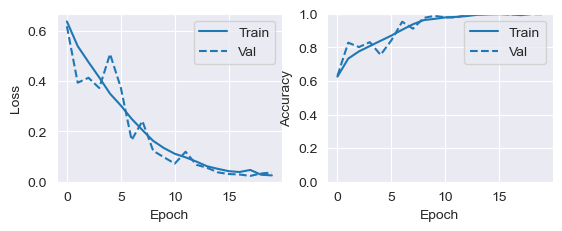

In [24]:
plot_metrics(resampled_history)

In [25]:
resampled_results = model.evaluate([test_data, test_categories], test_labels, batch_size=BATCH_SIZE, verbose=0)

In [26]:
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

loss :  0.035112615674734116
tp :  1609.0
fp :  0.0
tn :  348.0
fn :  7.0
accuracy :  0.996435821056366



In [27]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [28]:
test_predictions = model.predict([test_data, test_categories], batch_size=BATCH_SIZE)

16/16 [==============================] - 0s 3ms/step


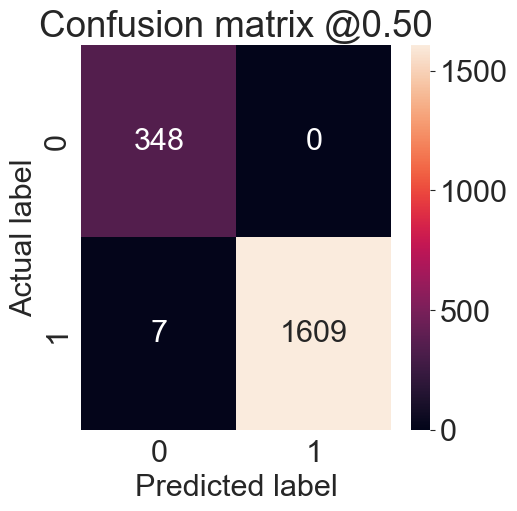

In [29]:
plt.rcParams.update({'font.size': 22})
plot_cm(test_labels, test_predictions)

In [35]:
pred = [0 if p < 0.5 else 1 for p in test_predictions]
wrong_predictions = [i for i in range(len(pred)) if pred[i] != test_labels[i]]
len(wrong_predictions)

7

In [54]:
wrong_trajectories = test_data[wrong_predictions]
wrong_categories = test_categories[wrong_predictions]

In [57]:
wrong_trajectories = np.reshape(np.transpose(wrong_trajectories, axes=[0, 2, 1]), [wrong_trajectories.shape[0], 100])

In [66]:
show_traj = []
for j in range(len(wrong_trajectories)):
    for i, d in enumerate(data):
        if np.array_equiv(d[1:-1].numpy(), wrong_trajectories[j]):
            show_traj.append(i)
            break

In [67]:
show_traj

[459, 8101, 8187, 8082, 3459, 8136, 3451]